In [2]:

import bz2
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')


Robust loader 

In [ ]:

def load_fasttext_bz2(path, encoding='utf-8', errors='replace', max_lines=None, show_progress=True):
    """
    Load a FastText-style .bz2 file where each line is like:
       __label__5 This is the review text ...
    Returns a DataFrame with columns ['label', 'text'].
    """
    labels = []
    texts = []
    
    with bz2.open(path, mode='rt', encoding=encoding, errors=errors) as f:
        iterator = f
        if show_progress:
      
            try:
                total = None
                from os import path as os_path
                if os_path.exists(path):
                    total = None
            except Exception:
                total = None
            iterator = tqdm(f, total=total)
        for i, line in enumerate(iterator):
            if max_lines is not None and i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue
            
            
            parts = line.split(' ', 1)
            if len(parts) == 1:
                continue
            label_token, text = parts[0], parts[1]
            m = re.search(r'(\d+)', label_token)
            if m:
                label = int(m.group(1))
            else:
                
                subparts = line.split('\t', 1)
                if len(subparts) > 1:
                    label_token = subparts[0]
                    text = subparts[1]
                    m = re.search(r'(\d+)', label_token)
                    if m:
                        label = int(m.group(1))
                    else:
                        continue
                else:
                    continue
            labels.append(label)
            texts.append(text)
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df


Paths (update if needed)

In [ ]:

train_path_windows = r"C:/Users/FAS/Downloads/archive/train.ft.txt.bz2"
test_path_windows  = r"C:/Users/FAS/Downloads/archive/test.ft.txt.bz2"

train_path_mnt = '/mnt/data/train.ft.txt.bz2'
test_path_mnt  = '/mnt/data/test.ft.txt.bz2'

train_path = train_path_windows
test_path  = test_path_windows
print('Using train path:', train_path)


Using train path: C:/Users/FAS/Downloads/archive/train.ft.txt.bz2


In [ ]:

MAX_LINES = None 
train_df = load_fasttext_bz2(train_path, encoding='utf-8', errors='replace', max_lines=MAX_LINES)
test_df  = load_fasttext_bz2(test_path,  encoding='utf-8', errors='replace', max_lines=MAX_LINES)
print('Train shape:', train_df.shape)
print('Test  shape:', test_df.shape)
display(train_df.head())


3600000it [02:27, 24398.04it/s]
400000it [00:18, 22011.32it/s]


Train shape: (3600000, 2)
Test  shape: (400000, 2)


,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


Inspect and normalize labels to 0..4 (1..5 -> 0..4)

In [ ]:

print('Unique labels (train):', sorted(train_df['label'].unique())[:20])
train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce').astype('Int64')
test_df['label']  = pd.to_numeric(test_df['label'], errors='coerce').astype('Int64')
train_df.dropna(subset=['label'], inplace=True)
test_df.dropna(subset=['label'], inplace=True)
train_df['label'] = train_df['label'].astype(int)
test_df['label']  = test_df['label'].astype(int)
if train_df['label'].min() >= 1:
    train_df['label'] = train_df['label'] - 1
    test_df['label']  = test_df['label'] - 1
print('Label distribution (train):')
print(train_df['label'].value_counts().sort_index())


Unique labels (train): [np.int64(1), np.int64(2)]
Label distribution (train):
label
0    1800000
1    1800000
Name: count, dtype: int64


Text cleaning

In [8]:

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def clean_text(text, remove_stopwords=True):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    if remove_stopwords:
        toks = [w for w in text.split() if w not in STOPWORDS]
        return ' '.join(toks)
    return text


from tqdm import tqdm
tqdm.pandas()
train_df['clean_text'] = train_df['text'].progress_apply(clean_text)
test_df['clean_text']  = test_df['text'].progress_apply(clean_text)
display(train_df[['label','clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FAS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
100%|██████████| 400000/400000 [00:29<00:00, 13658.06it/s]


,label,clean_text
0,1,stuning even non gamer sound track beautiful p...
1,1,best soundtrack ever anything reading lot revi...
2,1,amazing soundtrack favorite music time hands i...
3,1,excellent soundtrack truly like soundtrack enj...
4,1,remember pull jaw floor hearing played game kn...


Sample per class to speed up training

In [9]:

SAMPLE_PER_CLASS = 20000  
if SAMPLE_PER_CLASS is not None:
    sampled_frames = []
    for lbl in sorted(train_df['label'].unique()):
        subset = train_df[train_df['label']==lbl]
        sampled = subset.sample(min(len(subset), SAMPLE_PER_CLASS), random_state=42)
        sampled_frames.append(sampled)
    train_sample = pd.concat(sampled_frames).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    train_sample = train_df
print('Training size used:', len(train_sample))


Training size used: 40000


Train/validation split and TF-IDF vectorization

In [10]:

X = train_sample['clean_text'].values
y = train_sample['label'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
print('Feature shape:', X_train_vec.shape)


Feature shape: (32000, 20000)


Train multinomial Logistic Regression

In [11]:

model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, n_jobs=-1)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_val_vec)
print('Validation accuracy:', accuracy_score(y_val, y_pred))
print('\nClassification report:\n')
print(classification_report(y_val, y_pred, digits=4))


Validation accuracy: 0.878

Classification report:

              precision    recall  f1-score   support

           0     0.8818    0.8730    0.8774      4000
           1     0.8743    0.8830    0.8786      4000

    accuracy                         0.8780      8000
   macro avg     0.8780    0.8780    0.8780      8000
weighted avg     0.8780    0.8780    0.8780      8000



Confusion matrix

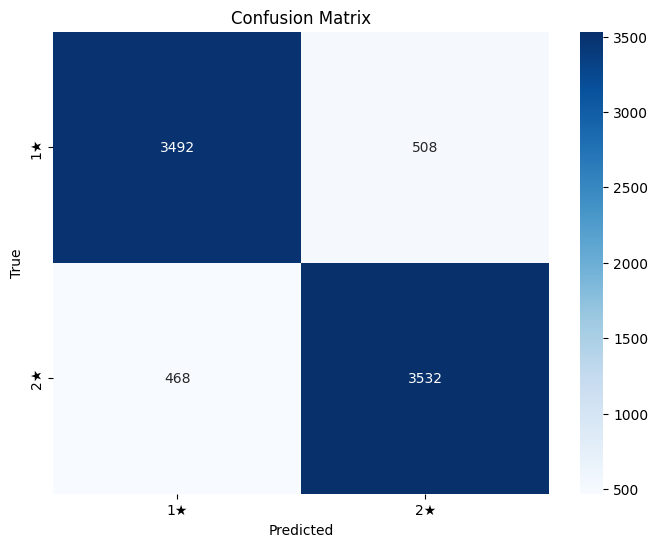

In [12]:

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i+1}★" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}★" for i in range(cm.shape[0])])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
